#LAB 7-1: Class activation map



## Class Activation Map(CAM) with Cifar10 dataset

## Class Activation Map(CAM) [1]
>- Simple technique to expose the implicit attention of Convolutional Neural Networks
>- Higlights the most discriminative (informative) image regions related to the predicted class

<img src="https://drive.google.com/uc?export=view&id=1PwZoN04bQbING9BIwSAcRr0ytdIZt4M3" alt="no_image" style="width: 900px;"/>

### Framework of CAM
>- Generating CAM using **Global Average Pooling(GAP)** in CNNs
>>- Perform GAP on the feature map($f_k(x,y)$) of unit k in the last convolutional layer(from any conventional CNN network, especially for the classification) : $F_k = \sum_{x,y} f_k(x,y)$
>>- Use those as features for a fully-connected layer that produces the desired output(categorical)
>- Compute a weighted sum of those feature maps to produce CAM
>>- Weight($w_k^c$): Fully-connnected layer's weight parameters corresponding to specific output class c for unit k
>>- Class Activation Map: $M_c(x,y) = \sum_{x,y} w_k^cf_k(x,y)$

<img src="https://drive.google.com/uc?export=view&id=1enNZKv0Z5oMRZy8bZ4AqjvoP3ipTZyp4" alt="no_image" style="width: 900px;"/>

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.model_zoo as model_zoo

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as v_utils

import matplotlib.pyplot as plt

import cv2
import io
import requests
import os
import copy
import time

from torchsummary import summary
from torch.utils.data import DataLoader
from PIL import Image
from collections import OrderedDict

%matplotlib inline

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#parameters
batch_size = 128
num_epoch = 150
num_classes = 10

##  Dataset (Cifar10)
>- All images are resized to 224$\times$224 for using ImageNet pretrained models

In [ ]:
print('STEP 1: DEFINE DATASET')

image_size = 224
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = dset.CIFAR10("./datasets/CIFAR10",
                             train=True,
                             transform=transform,
                             target_transform=None,
                             download=True)

image_size = 224
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_dataset = dset.CIFAR10("./datasets/CIFAR10",
                            train=False,
                            transform=transform,
                            target_transform=None,
                            download=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 1: DEFINE DATASET
Files already downloaded and verified


In [ ]:
print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))

Train dataset size: 50000
Test dataset size: 10000


In [ ]:
print('STEP 2: LOADING DATASET')

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,
                                           num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,
                                          num_workers=2,drop_last=True)

STEP 2: LOADING DATASET


##  Model
### Model Setup with popular CNNS(AlexNet[2], VGGnet[3])
>
>1. AlexNet
>    - Removing the layers after conv5(i.e., pool5 to prob) resulting in a mapping resolution of 13$\times$13 ($f_k(x,y)$ size)
>2. VGGnet
>    - Removing the layers after conv5-3(i.e., pool5 to prob) resulting in a mapping resolution of 14$\times$14 ($f_k(x,y)$ size)
>
> **++To each of the networks, adding a convolutional layer (kernel_size 3$\times$3, stride 1, pad 1 with 1024 filters), followed by a GAP and a softmax fully-connected layer with no bias**
>
>**++We use ImageNet pretrained ConvNet as a fixed feature extractor and train only common additional layers on the Cifar10 dataset**

### Pretraining and fine-tuning [4]
>- In practice, very few people train an entire CNN from scratch(with random initialization) because of data deficiency
>- It is more common to pretrain a ConvNet on a very large dataset (e.g. ImageNet) and use it as an initialization or a fixed feature
extractor
>- Pretrained models: Since modern ConvNets take 2-3 weeks to train on ImageNet, it is common to see people release their final ConvNet checkpoints for the benefit of others who can use the networks for fine-tuning
>- Pretrained ConvNet can be used with two scenarios
>>1. As fixed feature extractor
>>>- Take a ConvNet pretrained on ImageNet and remove the last fully-connected layer to extract feature of input data
>>>- After extracting feature, final classifier (e.g. softmax classifier) is trained for the new dataset
>>2. Fine-tuning
>>>- Fine-tuning is to not only replace or retrain the classifier of network, but to also retrain the weights of other pretrained layers by backpropagation for the new dataset
>>>- It is possible to fine-tune the whole network or some of the layers while other layers fixed
>- How to decide which scenario we should perform
>>- Several factors exist,but the two most important ones are related to the new dataset
>>>1. Size of dataset: Small or big
>>>2. Similarity to the original dataset : Data distribution, contents, variation...
>>- Model's capacity, task, etc can be factors we have to consider
>- Smaller learning rate usually used for fine-tuning, because we don't want to distort good pretrained ConvNet weights too quickly and too much
>
>**++We use both scenarios in this lab and then compare best accuracies of two methods**


In [ ]:
print('STEP 3: CREATE MODEL CLASS: AlexNet, VGGnet')

# Pre-trained AlexNet
class AlexNet_GAP(nn.Module):
    def __init__(self):
        super(AlexNet_GAP,self).__init__()
        # Feature extraction
        self.features = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        #CAM layers
        self.cam_conv = nn.Sequential(
            nn.Conv2d(256, num_classes, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.gap_layer = nn.AvgPool2d(13)
        self.fc_layer = nn.Linear(num_classes,num_classes, bias=False)

    def forward(self,x):
        batch_size = x.size(0)

        x = self.features(x)
        feature = self.cam_conv(x)
        x = self.gap_layer(feature)
        x = x.view(batch_size,-1)
        x = self.fc_layer(x)

        return feature, x


# Pre-trained VGGnet-13
class VGG_Block(nn.Module):
    def __init__(self, in_ch, out_ch, use_bnorm=False):
        super(VGG_Block, self).__init__()
        if use_bnorm:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels=in_ch,
                          out_channels=out_ch,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_ch,
                          out_channels=out_ch,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels=in_ch,
                          out_channels=out_ch,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_ch,
                          out_channels=out_ch,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        return self.conv(x)

class VGG_GAP(nn.Module):
    def __init__(self, use_bnorm):
        super(VGG_GAP, self).__init__()
        # Feature extraction
        self.features = nn.Sequential(VGG_Block(in_ch=3, out_ch=64, use_bnorm=use_bnorm),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      VGG_Block(in_ch=64, out_ch=128, use_bnorm=use_bnorm),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      VGG_Block(in_ch=128, out_ch=256, use_bnorm=use_bnorm),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      VGG_Block(in_ch=256, out_ch=512, use_bnorm=use_bnorm),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      VGG_Block(in_ch=512, out_ch=512, use_bnorm=use_bnorm)
                                     )

        # GAP
        self.cam_conv = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=num_classes,
                      kernel_size=3,
                      padding=1),
            nn.ReLU()
        )
        self.gap_layer = nn.AvgPool2d(14)
        self.fc_layer = nn.Linear(in_features=num_classes,
                                  out_features=num_classes,
                                  bias=False)

    def forward(self, x):
        batch_size = x.size(0)

        x = self.features(x)
        feature = self.cam_conv(x)
        x = self.gap_layer(feature)
        x = x.view(batch_size,-1)
        x = self.fc_layer(x)

        return feature, x

STEP 3: CREATE MODEL CLASS: AlexNet, VGGnet


In [ ]:
print('STEP 4: INSTANTIATE MODEL CLASS')
#Adapting pre-trained model to our model

pretrained_AlexNet = {'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',}
pretrained_vgg = {'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',}

def alexnet_GAP(model, pretrained=False):
    pretrained_dict = model_zoo.load_url(pretrained_AlexNet['alexnet'])
    model_dict = model.state_dict()

    if pretrained:
        # Get only features's weight from model zoo(pretrained weight)
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

    return model

model_AlexNet = alexnet_GAP(AlexNet_GAP(), pretrained=True)


def vgg_GAP(model, pretrained=False):
    pretrained_dict = model_zoo.load_url(pretrained_vgg['vgg13'])
    pretrained_key = list(pretrained_dict)

    new_state_dict = OrderedDict()

    model_dict = model.state_dict()

    if pretrained:
        for i, (key, value) in enumerate(model_dict.items()):
            # Get only feature's weight from model zoo(pretrained weight)
            if 'feature' in key:
                new_state_dict[key] = pretrained_dict[pretrained_key[i]]
            else:
                new_state_dict[key] = value

        model.load_state_dict(new_state_dict)
    return model

model_VGGnet = VGG_GAP(use_bnorm=False)
model_VGGnet = vgg_GAP(model_VGGnet, pretrained=True)

STEP 4: INSTANTIATE MODEL CLASS


In [ ]:
print("AlexNet's Summary:")
model_AlexNet.to(device)
summary(model_AlexNet, (3, 224, 224))


print("\nVGGnet's Summary:")
model_VGGnet.to(device)
summary(model_VGGnet, (3, 224, 224))

AlexNet's Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
           Conv2d-13           [-1, 10, 13, 13]          23,050
             ReLU-14

## Train/Test on the Cifar10 (Only AlexNet)

#### 1. ConvNet as a fixed feature extractor

In [ ]:
model_AlexNet = alexnet_GAP(AlexNet_GAP(), pretrained=True)
model_AlexNet.to(device) # Model to GPU

# For fixed feature extractor, gradients of modules in model.feature are not computed
for param in model_AlexNet.features.parameters():
    param.requires_grad = False

In [ ]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

#fixed feature extractor initial learning rate
learning_rate = 0.001

optimizer = torch.optim.Adam(model_AlexNet.parameters(), lr=learning_rate)
#learning rate scheduling
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.5, patience=15)

#Function to print current learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


print('STEP 6: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

STEP 5: INSTANTIATE OPTIMIZER CLASS
STEP 6: INSTANTIATE LOSS CLASS


In [ ]:
print('STEP 7: TRAIN THE MODEL')

best_acc = 0
for epoch in range(num_epoch):

    start = time.time()

    #Training
    model_AlexNet.train()
    for j, (img,label) in enumerate(train_loader):
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        feature, output = model_AlexNet(img)

        loss = criterion(output,label)

        loss.backward()

        optimizer.step()

        if j % 100 == 99:
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}'.format(
                   epoch,
                   j * len(img),
                   len(train_dataset),
                   100. * j / len(train_loader),
                   get_lr(optimizer),
                   loss.item()))

    # Test
    model_AlexNet.eval()
    correct = 0
    accuracy = 0

    for img,label in test_loader:

        img= img.to(device)
        label = label.to(device)

        feature, output = model_AlexNet(img)

        pred = output.data.max(1, keepdim = True)[1]
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()

    accuracy = 100. * correct.item() / len(test_dataset)

    print('\nTest set accuracy: {}/{} ({:.4f}%) \n'
            .format(correct, len(test_dataset), accuracy))

    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))

    '''
    # save model
    if accuracy > best_acc :
        torch.save({
           'epoch': epoch,
            'model_state_dict': model_AlexNet.state_dict(),
           'optimizer_state_dict': optimizer.state_dict(),
           'loss': loss,
           'accuracy': accuracy

           }, './path/to/save/model/best_model_AlexNet.tar')

        best_acc = accuracy
    '''

    scheduler.step(accuracy)

STEP 7: TRAIN THE MODEL
Train Epoch: 0 [12672/50000 (25%) / Learning rate:0.001]	Loss:1.230613
Train Epoch: 0 [25472/50000 (51%) / Learning rate:0.001]	Loss:1.133997
Train Epoch: 0 [38272/50000 (77%) / Learning rate:0.001]	Loss:1.002853

Test set accuracy: 6777/10000 (67.7700%) 

////Epoch elapsed time: 36.9271936416626////

Train Epoch: 1 [12672/50000 (25%) / Learning rate:0.001]	Loss:1.072667
Train Epoch: 1 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.961338
Train Epoch: 1 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.861068

Test set accuracy: 7047/10000 (70.4700%) 

////Epoch elapsed time: 35.978779554367065////

Train Epoch: 2 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.731377
Train Epoch: 2 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.789343
Train Epoch: 2 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.883968

Test set accuracy: 7278/10000 (72.7800%) 

////Epoch elapsed time: 35.2631139755249////

Train Epoch: 3 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.8


Test set accuracy: 7767/10000 (77.6700%) 

////Epoch elapsed time: 33.534183502197266////

Train Epoch: 27 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.631852
Train Epoch: 27 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.664793
Train Epoch: 27 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.610795

Test set accuracy: 7770/10000 (77.7000%) 

////Epoch elapsed time: 33.84017634391785////

Train Epoch: 28 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.487870
Train Epoch: 28 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.540834
Train Epoch: 28 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.667276

Test set accuracy: 7759/10000 (77.5900%) 

////Epoch elapsed time: 33.52983260154724////

Train Epoch: 29 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.654931
Train Epoch: 29 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.626238
Train Epoch: 29 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.665186

Test set accuracy: 7752/10000 (77.5200%) 

////Epoch elapsed time: 33.7275321

Train Epoch: 53 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.698944

Test set accuracy: 7849/10000 (78.4900%) 

////Epoch elapsed time: 34.17800283432007////

Train Epoch: 54 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.667914
Train Epoch: 54 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.516666
Train Epoch: 54 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.545451

Test set accuracy: 7826/10000 (78.2600%) 

////Epoch elapsed time: 35.42536282539368////

Train Epoch: 55 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.461145
Train Epoch: 55 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.616406
Train Epoch: 55 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.616877

Test set accuracy: 7827/10000 (78.2700%) 

////Epoch elapsed time: 34.535791873931885////

Train Epoch: 56 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.585822
Train Epoch: 56 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.609143
Train Epoch: 56 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.471332

Test 

Train Epoch: 80 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.526152
Train Epoch: 80 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.437300

Test set accuracy: 7905/10000 (79.0500%) 

////Epoch elapsed time: 33.392356395721436////

Train Epoch: 81 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.397881
Train Epoch: 81 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.592981
Train Epoch: 81 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.490453

Test set accuracy: 7876/10000 (78.7600%) 

////Epoch elapsed time: 33.15156817436218////

Train Epoch: 82 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.463486
Train Epoch: 82 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.483824
Train Epoch: 82 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.415490

Test set accuracy: 7879/10000 (78.7900%) 

////Epoch elapsed time: 33.69847345352173////

Train Epoch: 83 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.778200
Train Epoch: 83 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.512075
Train 

Train Epoch: 107 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.602055
Train Epoch: 107 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.582917
Train Epoch: 107 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.606568

Test set accuracy: 7951/10000 (79.5100%) 

////Epoch elapsed time: 33.20831084251404////

Train Epoch: 108 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.638775
Train Epoch: 108 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.494928
Train Epoch: 108 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.615149

Test set accuracy: 7981/10000 (79.8100%) 

////Epoch elapsed time: 33.285500049591064////

Train Epoch: 109 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.552357
Train Epoch: 109 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.468636
Train Epoch: 109 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.406660

Test set accuracy: 7975/10000 (79.7500%) 

////Epoch elapsed time: 33.21178698539734////

Train Epoch: 110 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.455

Train Epoch: 133 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.379056

Test set accuracy: 7953/10000 (79.5300%) 

////Epoch elapsed time: 33.65664720535278////

Train Epoch: 134 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.503652
Train Epoch: 134 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.549687
Train Epoch: 134 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.679971

Test set accuracy: 7992/10000 (79.9200%) 

////Epoch elapsed time: 33.61249566078186////

Train Epoch: 135 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.485853
Train Epoch: 135 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.544515
Train Epoch: 135 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.389753

Test set accuracy: 7987/10000 (79.8700%) 

////Epoch elapsed time: 33.401204347610474////

Train Epoch: 136 [12672/50000 (25%) / Learning rate:0.001]	Loss:0.579199
Train Epoch: 136 [25472/50000 (51%) / Learning rate:0.001]	Loss:0.464015
Train Epoch: 136 [38272/50000 (77%) / Learning rate:0.001]	Loss:0.524

#### 2. Fine-tuning

In [ ]:
model_AlexNet = alexnet_GAP(AlexNet_GAP(), pretrained=True)
model_AlexNet.to(device) # Model to GPU

print('STEP 5: INSTANTIATE OPTIMIZER CLASS')
#fine-tuning initial learning rate
learning_rate = 0.0001

optimizer = torch.optim.Adam(model_AlexNet.parameters(), lr=learning_rate)
#learning rate scheduling
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.5, patience=15)

#Function to print current learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


print('STEP 6: INSTANTIATE LOSS CLASS')
criterion = nn.CrossEntropyLoss()

Get weight from pretrained weight
STEP 5: INSTANTIATE OPTIMIZER CLASS
STEP 6: INSTANTIATE LOSS CLASS


In [ ]:
print('STEP 7: TRAIN THE MODEL')

best_acc = 0
for epoch in range(num_epoch):

    start = time.time()

    #Training
    model_AlexNet.train()
    for j, (img,label) in enumerate(train_loader):
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        feature, output = model_AlexNet(img)

        loss = criterion(output,label)

        loss.backward()

        optimizer.step()

        if j % 100 == 99:
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}'.format(
                   epoch,
                   j * len(img),
                   len(train_dataset),
                   100. * j / len(train_loader),
                   get_lr(optimizer),
                   loss.item()))

    # Test
    model_AlexNet.eval()
    correct = 0
    accuracy = 0

    for img,label in test_loader:

        img= img.to(device)
        label = label.to(device)

        feature, output = model_AlexNet(img)

        pred = output.data.max(1, keepdim = True)[1]
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()

    accuracy = 100. * correct.item() / len(test_dataset)

    print('\nTest set accuracy: {}/{} ({:.4f}%) \n'
            .format(correct, len(test_dataset), accuracy))

    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))

    '''
    # save model
    if accuracy > best_acc :
        #torch.save({
        #    'epoch': epoch,
        #     'model_state_dict': model_AlexNet.state_dict(),
        #    'optimizer_state_dict': optimizer.state_dict(),
        #    'loss': loss,
        #    'accuracy': accuracy

        #    }, './path/to/save/model/best_model_AlexNet.tar')

        best_acc = accuracy
    '''
    scheduler.step(accuracy)

STEP 7: TRAIN THE MODEL
Train Epoch: 0 [12672/50000 (25%) / Learning rate:0.0001]	Loss:1.538225
Train Epoch: 0 [25472/50000 (51%) / Learning rate:0.0001]	Loss:1.116867
Train Epoch: 0 [38272/50000 (77%) / Learning rate:0.0001]	Loss:0.959031

Test set accuracy: 6873/10000 (68.7300%) 

////Epoch elapsed time: 34.30977654457092////

Train Epoch: 1 [12672/50000 (25%) / Learning rate:0.0001]	Loss:1.038679
Train Epoch: 1 [25472/50000 (51%) / Learning rate:0.0001]	Loss:0.678493
Train Epoch: 1 [38272/50000 (77%) / Learning rate:0.0001]	Loss:0.944594

Test set accuracy: 7665/10000 (76.6500%) 

////Epoch elapsed time: 35.34765625////

Train Epoch: 2 [12672/50000 (25%) / Learning rate:0.0001]	Loss:0.676624
Train Epoch: 2 [25472/50000 (51%) / Learning rate:0.0001]	Loss:0.713078
Train Epoch: 2 [38272/50000 (77%) / Learning rate:0.0001]	Loss:0.563385

Test set accuracy: 7946/10000 (79.4600%) 

////Epoch elapsed time: 34.84141755104065////

Train Epoch: 3 [12672/50000 (25%) / Learning rate:0.0001]	Los

Train Epoch: 26 [38272/50000 (77%) / Learning rate:0.0001]	Loss:0.084377

Test set accuracy: 8880/10000 (88.8000%) 

////Epoch elapsed time: 35.00740671157837////

Train Epoch: 27 [12672/50000 (25%) / Learning rate:0.0001]	Loss:0.147337
Train Epoch: 27 [25472/50000 (51%) / Learning rate:0.0001]	Loss:0.109450
Train Epoch: 27 [38272/50000 (77%) / Learning rate:0.0001]	Loss:0.098384

Test set accuracy: 8925/10000 (89.2500%) 

////Epoch elapsed time: 35.14704704284668////

Train Epoch: 28 [12672/50000 (25%) / Learning rate:0.0001]	Loss:0.126817
Train Epoch: 28 [25472/50000 (51%) / Learning rate:0.0001]	Loss:0.138617
Train Epoch: 28 [38272/50000 (77%) / Learning rate:0.0001]	Loss:0.137476

Test set accuracy: 8855/10000 (88.5500%) 

////Epoch elapsed time: 35.346301317214966////

Train Epoch: 29 [12672/50000 (25%) / Learning rate:0.0001]	Loss:0.089823
Train Epoch: 29 [25472/50000 (51%) / Learning rate:0.0001]	Loss:0.084840
Train Epoch: 29 [38272/50000 (77%) / Learning rate:0.0001]	Loss:0.025

Train Epoch: 53 [12672/50000 (25%) / Learning rate:5e-05]	Loss:0.001305
Train Epoch: 53 [25472/50000 (51%) / Learning rate:5e-05]	Loss:0.001456
Train Epoch: 53 [38272/50000 (77%) / Learning rate:5e-05]	Loss:0.005359

Test set accuracy: 9059/10000 (90.5900%) 

////Epoch elapsed time: 35.016059160232544////

Train Epoch: 54 [12672/50000 (25%) / Learning rate:5e-05]	Loss:0.004587
Train Epoch: 54 [25472/50000 (51%) / Learning rate:5e-05]	Loss:0.000547
Train Epoch: 54 [38272/50000 (77%) / Learning rate:5e-05]	Loss:0.001907

Test set accuracy: 8831/10000 (88.3100%) 

////Epoch elapsed time: 35.3273069858551////

Train Epoch: 55 [12672/50000 (25%) / Learning rate:5e-05]	Loss:0.008338
Train Epoch: 55 [25472/50000 (51%) / Learning rate:5e-05]	Loss:0.009931
Train Epoch: 55 [38272/50000 (77%) / Learning rate:5e-05]	Loss:0.005577

Test set accuracy: 8999/10000 (89.9900%) 

////Epoch elapsed time: 35.07473611831665////

Train Epoch: 56 [12672/50000 (25%) / Learning rate:5e-05]	Loss:0.003232
Train E


Test set accuracy: 9045/10000 (90.4500%) 

////Epoch elapsed time: 35.054688453674316////

Train Epoch: 80 [12672/50000 (25%) / Learning rate:2.5e-05]	Loss:0.000037
Train Epoch: 80 [25472/50000 (51%) / Learning rate:2.5e-05]	Loss:0.000118
Train Epoch: 80 [38272/50000 (77%) / Learning rate:2.5e-05]	Loss:0.000094

Test set accuracy: 9036/10000 (90.3600%) 

////Epoch elapsed time: 35.05899095535278////

Train Epoch: 81 [12672/50000 (25%) / Learning rate:2.5e-05]	Loss:0.000051
Train Epoch: 81 [25472/50000 (51%) / Learning rate:2.5e-05]	Loss:0.000015
Train Epoch: 81 [38272/50000 (77%) / Learning rate:2.5e-05]	Loss:0.000018

Test set accuracy: 9057/10000 (90.5700%) 

////Epoch elapsed time: 35.22075176239014////

Train Epoch: 82 [12672/50000 (25%) / Learning rate:2.5e-05]	Loss:0.000036
Train Epoch: 82 [25472/50000 (51%) / Learning rate:2.5e-05]	Loss:0.000065
Train Epoch: 82 [38272/50000 (77%) / Learning rate:2.5e-05]	Loss:0.000124

Test set accuracy: 9030/10000 (90.3000%) 

////Epoch elapse


Test set accuracy: 9054/10000 (90.5400%) 

////Epoch elapsed time: 35.139967918395996////

Train Epoch: 106 [12672/50000 (25%) / Learning rate:6.25e-06]	Loss:0.000028
Train Epoch: 106 [25472/50000 (51%) / Learning rate:6.25e-06]	Loss:0.000020
Train Epoch: 106 [38272/50000 (77%) / Learning rate:6.25e-06]	Loss:0.000005

Test set accuracy: 9019/10000 (90.1900%) 

////Epoch elapsed time: 35.005128383636475////

Train Epoch: 107 [12672/50000 (25%) / Learning rate:6.25e-06]	Loss:0.000020
Train Epoch: 107 [25472/50000 (51%) / Learning rate:6.25e-06]	Loss:0.000016
Train Epoch: 107 [38272/50000 (77%) / Learning rate:6.25e-06]	Loss:0.000014

Test set accuracy: 9029/10000 (90.2900%) 

////Epoch elapsed time: 35.08429789543152////

Train Epoch: 108 [12672/50000 (25%) / Learning rate:6.25e-06]	Loss:0.000022
Train Epoch: 108 [25472/50000 (51%) / Learning rate:6.25e-06]	Loss:0.000019
Train Epoch: 108 [38272/50000 (77%) / Learning rate:6.25e-06]	Loss:0.000006

Test set accuracy: 9035/10000 (90.3500%)

Train Epoch: 131 [38272/50000 (77%) / Learning rate:3.125e-06]	Loss:0.000008

Test set accuracy: 9038/10000 (90.3800%) 

////Epoch elapsed time: 35.11906123161316////

Train Epoch: 132 [12672/50000 (25%) / Learning rate:3.125e-06]	Loss:0.000005
Train Epoch: 132 [25472/50000 (51%) / Learning rate:3.125e-06]	Loss:0.000004
Train Epoch: 132 [38272/50000 (77%) / Learning rate:3.125e-06]	Loss:0.000004

Test set accuracy: 9031/10000 (90.3100%) 

////Epoch elapsed time: 35.21629786491394////

Train Epoch: 133 [12672/50000 (25%) / Learning rate:3.125e-06]	Loss:0.000004
Train Epoch: 133 [25472/50000 (51%) / Learning rate:3.125e-06]	Loss:0.000006
Train Epoch: 133 [38272/50000 (77%) / Learning rate:3.125e-06]	Loss:0.000004

Test set accuracy: 9029/10000 (90.2900%) 

////Epoch elapsed time: 35.22119355201721////

Train Epoch: 134 [12672/50000 (25%) / Learning rate:3.125e-06]	Loss:0.000011
Train Epoch: 134 [25472/50000 (51%) / Learning rate:3.125e-06]	Loss:0.000003
Train Epoch: 134 [38272/50000 (77%

>- Best accuracies
>>- Fixed featrue extractor(\~80%) / Fine-tuning(\~90%)
>- Our dataset(Cifar10) vs Original dataset(ImageNet)
>>- Number of data : 50,000 vs ~1.2M
>>- Number of class: 10 vs 1,000
>>- Varations: Small vs Large
>- Cifar10 is not too small and AlexNet's capacity is not too big: <br>
Our model avoids overfitting when fine-tuning
>- So when fine-tuning, dataset-specific features are trained well based on pretrained generic visual features

## CAM Visualization(AlexNet, VGGnet)


In [ ]:
cam_test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1, shuffle=False,
                                              num_workers=2,drop_last=True)

In [ ]:
# Create CAM generator class

class CAM():
    def __init__(self, model):
        self.model = model
        self.model.eval()
        #Weights for weighted sum
        self.weights = torch.transpose(self.model.fc_layer.weight.detach(), 0, 1)

    def forward_model(self,x):
        x = self.model.features(x)
        # Feature maps of the last convolutional layer
        feature = self.model.cam_conv(x)
        x = self.model.gap_layer(feature)
        x = x.view(x.size(0),-1)
        x = self.model.fc_layer(x)

        return feature, F.softmax(x, dim=1)

    def gen_CAM(self, img):
        conv_features, output = self.forward_model(img)
        output_index = torch.max(output, dim=1).indices

        # output specific fc_layer weight
        weights = self.weights[:,output_index].cpu().data.numpy()
        activation = conv_features.cpu().data.numpy()[0]

        cam = np.ones(activation.shape[1:])

        for i, weight in enumerate(weights):
            cam += weight*activation[i]

        #feature map resize to image size(224*224)
        cam = cv2.resize(cam, (img.size(2),img.size(3)))
        cam = (cam-np.min(cam))/(np.max(cam) - np.min(cam) + 1e-08) # Min/Max Normalization

        return cam, output_index.item()

In [ ]:
#tensor to array image
def reprocess_image(img):
    '''
    Args
    img(input): Normalized image [-1, 1]
    img_re(output): Unnormalized image [0, 1]
    '''
    img = torch.squeeze(img, 0)
    img_re = copy.copy(img.cpu().data.numpy())

    mean = 0.5
    std = 0.5

    # Unnormalize the image
    img_re = img_re * std
    img_re = img_re + mean

    # Image Clippng
    img_re = np.clip(img_re, 0, 1)

    # Change dimensions to (H, W, C)
    img_re = img_re.transpose(1, 2, 0)

    return img_re

In [ ]:
#Load our best finetuned model
model_AlexNet = alexnet_GAP(AlexNet_GAP(), pretrained=False)

checkpoint = torch.load('./path/to/save/model/best_model_AlexNet.tar', map_location="cuda:0")
model_AlexNet.load_state_dict(checkpoint['model_state_dict'])


#Load our best finetuned model
model_VGGnet = VGG_GAP(use_bnorm=False)
model_VGGnet = vgg_GAP(model_VGGnet, pretrained=False)

checkpoint = torch.load('./path/to/save/model/best_model_VGGNet.tar', map_location="cuda:0")
model_VGGnet.load_state_dict(checkpoint['model_state_dict'])


model_AlexNet.to(device)
model_VGGnet.to(device)


cam_Alex = CAM(model_AlexNet)
cam_VGG = CAM(model_VGGnet)

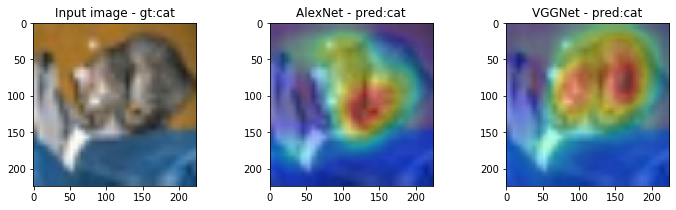

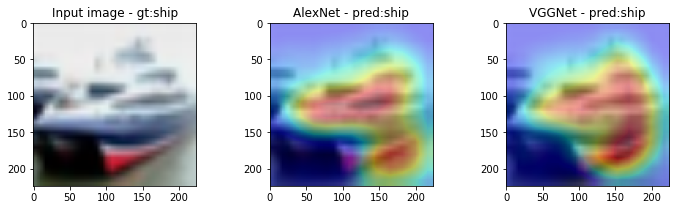

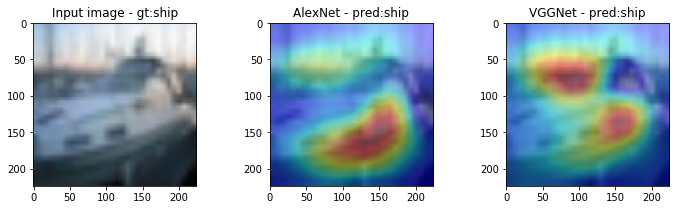

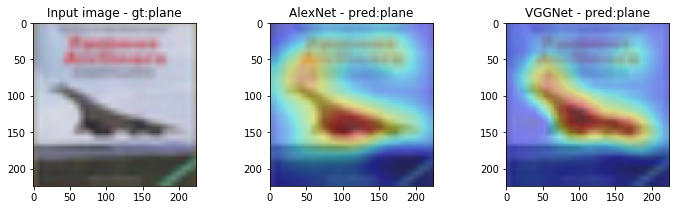

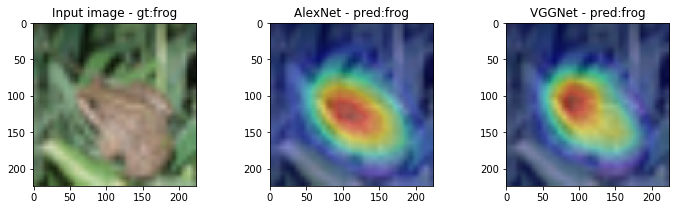

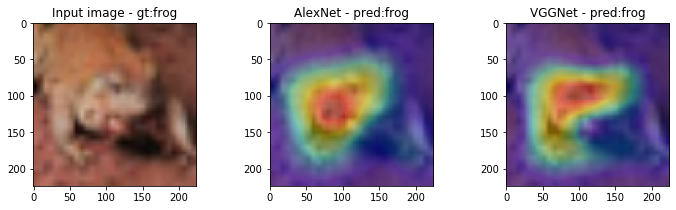

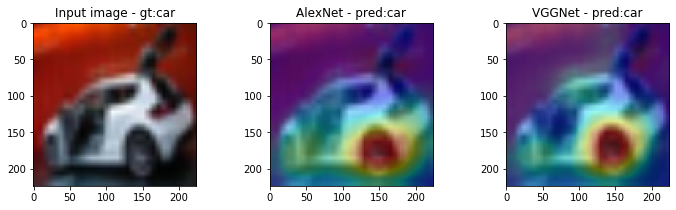

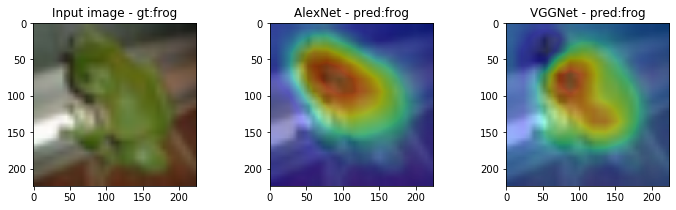

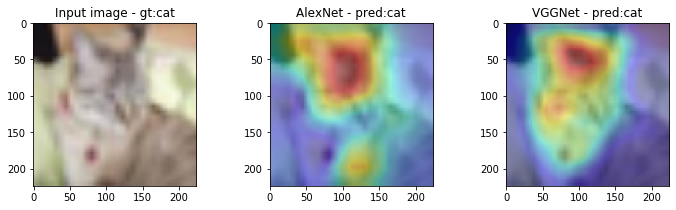

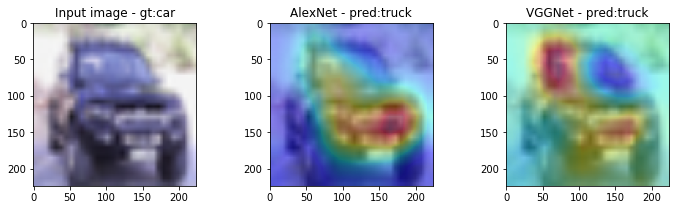

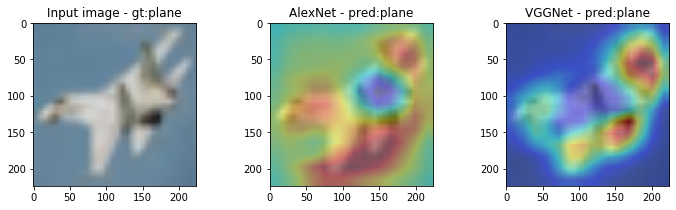

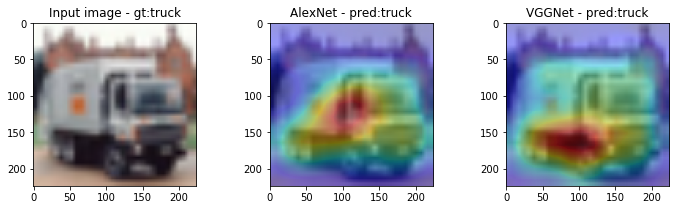

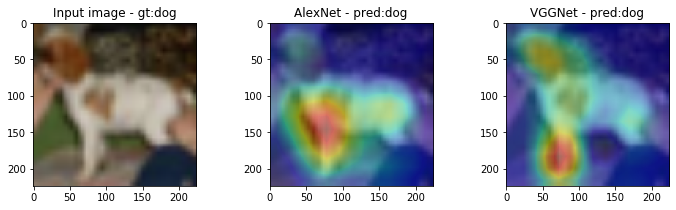

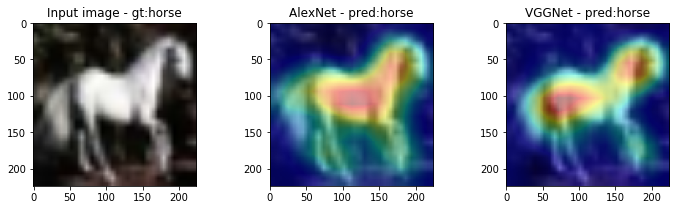

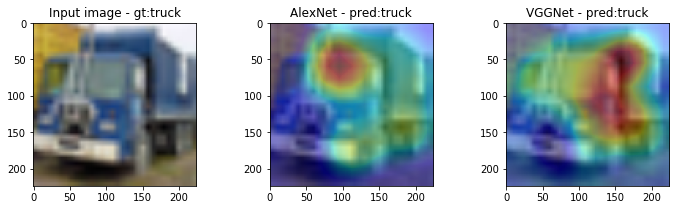

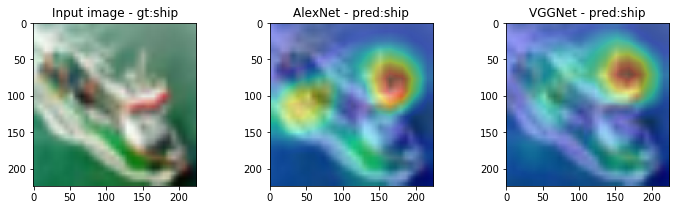

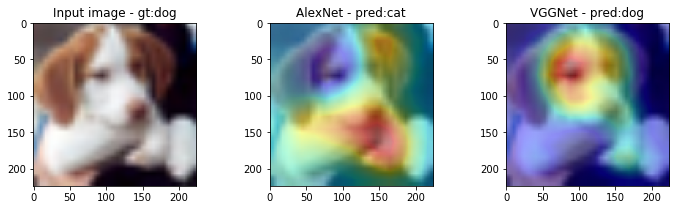

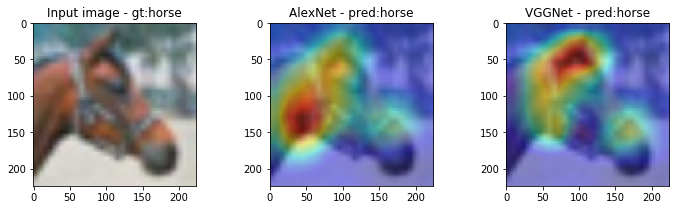

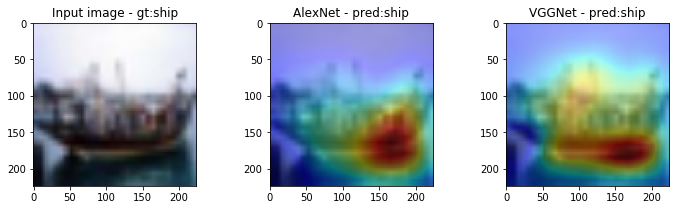

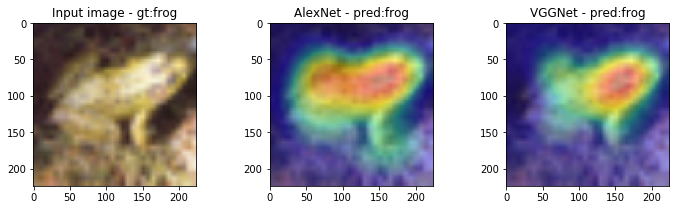

In [ ]:
for i, (img, label) in enumerate(cam_test_loader):
    cam_img_AlexNet , pred_AlexNet = cam_Alex.gen_CAM(img.to(device))
    cam_img_VGGNet , pred_VGGNet = cam_VGG.gen_CAM(img.to(device))

    fig = plt.figure(figsize=(12, 3))
    fig.add_subplot(1,3,1).set_title('Input image - gt:{}'.format(classes[label.item()]))
    plt.imshow(reprocess_image(img))
    fig.add_subplot(1,3,2).set_title('AlexNet - pred:{}'.format(classes[pred_AlexNet]))
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_AlexNet, alpha=0.4, cmap='jet')
    fig.add_subplot(1,3,3).set_title('VGGNet - pred:{}'.format(classes[pred_VGGNet]))
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_VGGNet, alpha=0.4, cmap='jet')
    plt.show()

    if (i+1) == 20:
        break

### *References*
[1] https://arxiv.org/abs/1512.04150 <br>
[2] https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf <br>
[3] https://arxiv.org/pdf/1409.1556.pdf <br>
[4] http://cs231n.github.io/transfer-learning/